In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub
from pathlib import Path

# Download latest version (returns a directory path)
path = Path(kagglehub.dataset_download("shivamb/netflix-shows"))
print("Path to dataset files:", path)

# Point to the CSV inside the downloaded folder
default_csv = path / "netflix_titles.csv"
if default_csv.exists():
    csv_path = default_csv
else:
    # Fallback: search for any CSV within the folder
    candidates = list(path.rglob("*.csv"))
    if not candidates:
        raise FileNotFoundError(f"No CSV files found under {path}")
    csv_path = candidates[0]
    print("Using detected CSV:", csv_path)

df = pd.read_csv(csv_path)
df.head()

Path to dataset files: C:\Users\aamin\.cache\kagglehub\datasets\shivamb\netflix-shows\versions\5


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


## Data cleaning and imputation

In [ ]:
print(df.isnull().sum())

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [ ]:
for i in df.columns:
    null_rate = df[i].isna().sum() / len(df) * 100
    if null_rate > 0 :
        print("{} null rate: {}%".format(i,round(null_rate,2)))

director null rate: 29.91%
cast null rate: 9.37%
country null rate: 9.44%
date_added null rate: 0.11%
rating null rate: 0.05%
duration null rate: 0.03%


Six columns have missing values (Director ~30%).

### Strategy
- **Country**: impute with mode.
- **Cast** and **Director**: fill with “No Data”.
- **Others (<5% missing)**: drop rows.

This preserves coverage while minimizing bias from heavy imputations.

In [ ]:
df['country'] = df['country'].fillna(df['country'].mode()[0])
df['cast'] = df['cast'].replace(np.nan, 'No Data')
df['director'] = df['director'].replace(np.nan, 'No Data')

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [ ]:
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

Missing values are handled. Next, convert `date_added` to datetime and derive calendar features.

In [ ]:
df["date_added"] = pd.to_datetime(df['date_added'], format="mixed")

df['month_added']=df['date_added'].dt.month
df['month_name_added']=df['date_added'].dt.month_name()
df['year_added'] = df['date_added'].dt.year

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8790 entries, 0 to 8806
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   show_id           8790 non-null   object        
 1   type              8790 non-null   object        
 2   title             8790 non-null   object        
 3   director          8790 non-null   object        
 4   cast              8790 non-null   object        
 5   country           8790 non-null   object        
 6   date_added        8790 non-null   datetime64[ns]
 7   release_year      8790 non-null   int64         
 8   rating            8790 non-null   object        
 9   duration          8790 non-null   object        
 10  listed_in         8790 non-null   object        
 11  description       8790 non-null   object        
 12  month_added       8790 non-null   int32         
 13  month_name_added  8790 non-null   object        
 14  year_added        8790 non-nu

### Feature engineering
Many titles list multiple countries. To avoid double-counting, extract the first listed country as the primary `first_country` for aggregation.

In [ ]:
# Quick feature engineering

# Helper column for various plots
df['count'] = 1

# Many productions have several countries listed - this will skew our results, so we'll grab the first one mentioned

# Let's retrieve just the first country
df['first_country'] = df['country'].apply(lambda x: x.split(",")[0])
df['first_country'].head()

0    United States
1     South Africa
2    United States
3    United States
4            India
Name: first_country, dtype: object

### Distribution of Content Types on Netflix (Movie vs TV Show)

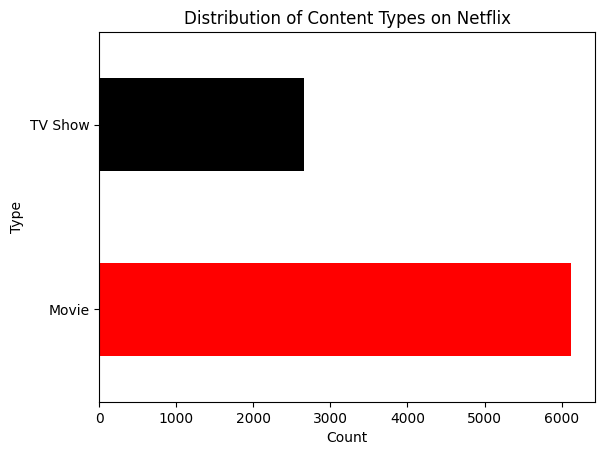

In [ ]:
df['type'] = df['type'].astype('category')
df['type'].value_counts().plot(kind='barh', color=['red', 'black'])
plt.title('Distribution of Content Types on Netflix')
plt.ylabel('Type')
plt.xlabel('Count')
plt.show()

#### key takeaways
- **Movies** outnumber **TV Shows** in this catalog.


### Ratio of Movies and TV shows

C:\Users\aamin\AppData\Local\Temp\ipykernel_21736\3705767470.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x=df.groupby(['type'])['type'].count()


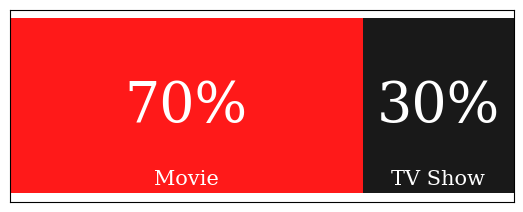

In [ ]:
# For viz: Ratio of Movies & TV shows

x=df.groupby(['type'])['type'].count()
y=len(df)
r=((x/y)).round(2)

mf_ratio = pd.DataFrame(r).T
fig, ax = plt.subplots(1,1,figsize=(6.5, 2.5))

ax.barh(mf_ratio.index, mf_ratio['Movie'], 
        color='red', alpha=0.9, label='Male', height=0.6)
ax.barh(mf_ratio.index, mf_ratio['TV Show'], left=mf_ratio['Movie'], 
        color='black', alpha=0.9, label='Female', height=0.6)

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_yticklabels(mf_ratio.index, fontfamily='serif', fontsize=11)


# movie percentage
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Movie'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Movie", 
                   xy=(mf_ratio['Movie'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')
    
    
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['TV Show'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("TV Show", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')


# Removing legend due to labelled plot
ax.legend().set_visible(False)
plt.show()

#### key takeaways
- **Movies** constitute the majority share; **TV Shows** make up the remainder.


### TV Show duration buckets (number of seasons)

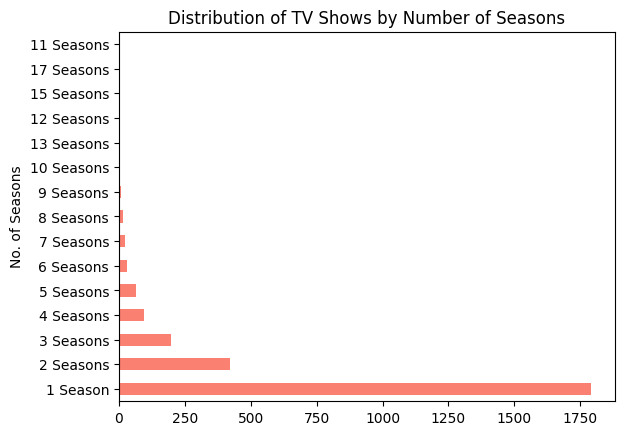

In [ ]:

ax = df.loc[df['type'] == 'TV Show', 'duration'].value_counts().plot(kind='barh', color='salmon')
ax.set_title('Distribution of TV Shows by Number of Seasons')
ax.set_ylabel('No. of Seasons')
plt.show()

#### key takeaways
- **Short‑run series (1–3 seasons)** dominate; long‑running shows are rare.
- The >9 seasons list confirms how uncommon long runs are.


### TV shows with more than 9 seasons

In [ ]:
# Filter for TV Shows with more than 9 seasons in the 'duration' column
# First, extract the number of seasons from 'duration'
tv_shows = df[df['type'] == 'TV Show'].copy()
# Extract the number as int where duration is like 'X Seasons' or '1 Season'
tv_shows['num_seasons'] = tv_shows['duration'].str.extract(r'(\d+)').astype(int)
# Filter for shows with more than 9 seasons
tv_shows_gt9 = tv_shows[tv_shows['num_seasons'] > 9]

# Display the count and the titles with their season counts
print(f"Number of TV Shows with more than 9 seasons: {len(tv_shows_gt9)}")
print(tv_shows_gt9[['title', 'num_seasons']])



Number of TV Shows with more than 9 seasons: 14
                                   title  num_seasons
390                     The Walking Dead           10
548                       Grey's Anatomy           17
1354                           Heartland           13
1622                       Stargate SG-1           10
1759  LEGO Ninjago: Masters of Spinjitzu           10
2203                    Shameless (U.S.)           10
2423                        Supernatural           15
4220              COMEDIANS of the world           13
4798                                NCIS           15
4964                   Trailer Park Boys           12
5412                      Criminal Minds           12
5908    Danger Mouse: Classic Collection           10
6456                              Cheers           11
6549                          Dad's Army           10


### Movies with Min & Max duration in minutes

In [ ]:
# Create a column 'movies_duration' to store duration in minutes for movies only
df['movies_duration'] = df.apply(
    lambda row: int(row['duration'].split()[0]) if row['type'] == 'Movie' and pd.notnull(row['duration']) and 'min' in row['duration'] else None, axis=1
)

# Drop missing movie durations for robust min/max
movie_durations = df[df['type'] == 'Movie']['movies_duration'].dropna()

if not movie_durations.empty:
    max_duration = movie_durations.max()
    min_duration = movie_durations.min()
    max_movie = df[(df['type'] == 'Movie') & (df['movies_duration'] == max_duration)].iloc[0]
    min_movie = df[(df['type'] == 'Movie') & (df['movies_duration'] == min_duration)].iloc[0]
    
    print(f"Min duration: {min_movie['title']} ({min_duration} min)")
    print(f"Max duration: {max_movie['title']} ({max_duration} min)")




Min duration: Silent (3.0 min)
Max duration: Black Mirror: Bandersnatch (312.0 min)


### Top countries by number of TV Shows and by number of Movies.


Countries with the most movies in total:
first_country
United States     2800
India              927
United Kingdom     382
Canada             187
France             148
                  ... 
Slovenia             1
Guatemala            1
Jamaica              1
Somalia              1
Croatia              1
Name: count, Length: 79, dtype: int64


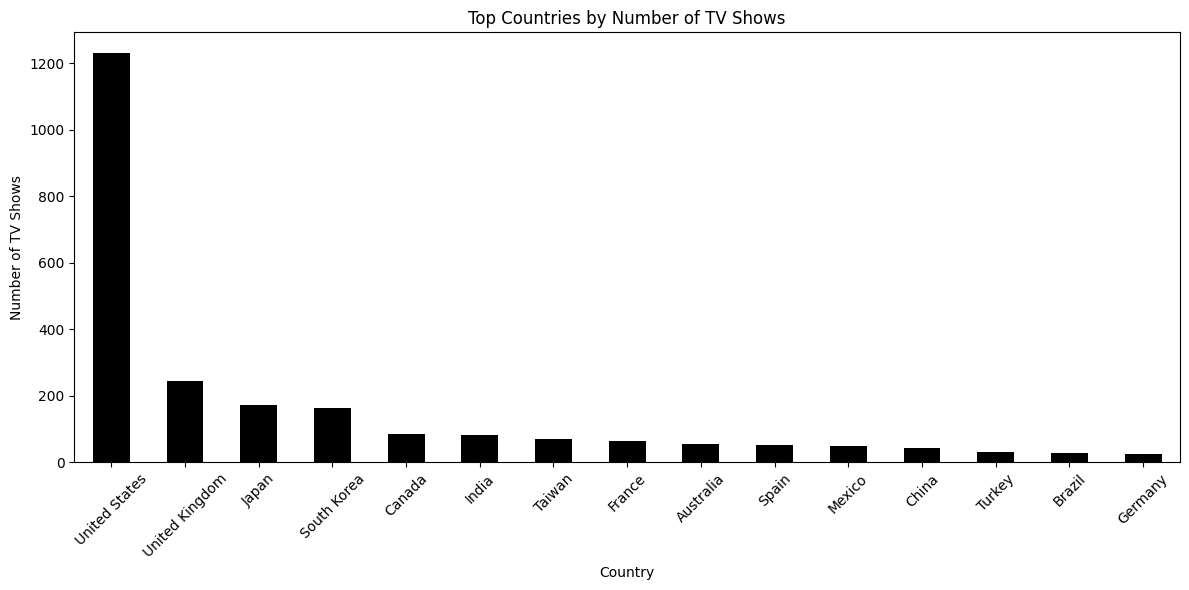

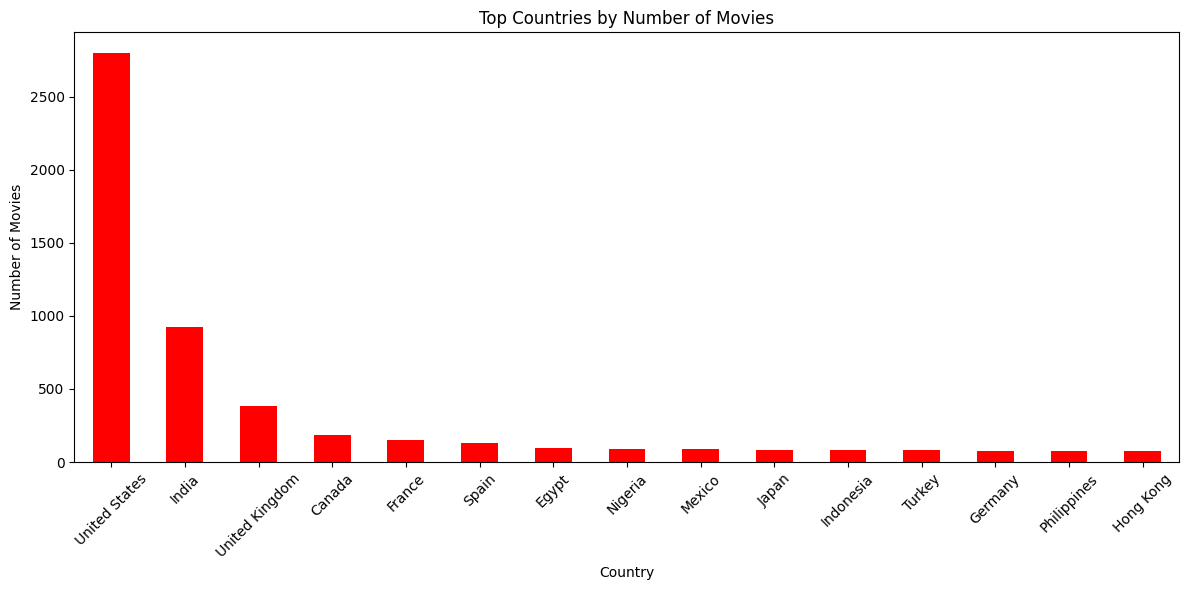

In [ ]:
# Group by 'country' and count the number of movies (type == "Movie")
movies_by_country = df[df['type'] == 'Movie']['first_country'].value_counts()
print("Countries with the most movies in total:")
print(movies_by_country)

# Plot the countries with the most movies
# Plot the countries with the most TV shows

# For TV Shows
tvshows_by_country = df[df['type'] == 'TV Show']['first_country'].value_counts()
plt.figure(figsize=(12,6))
tvshows_by_country.head(15).plot(kind='bar', color='black')
plt.title('Top Countries by Number of TV Shows')
plt.xlabel('Country')
plt.ylabel('Number of TV Shows')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.figure(figsize=(12,6))
# You might want to show just the top 10 or 15 for clarity
movies_by_country.head(15).plot(kind='bar', color='red')
plt.title('Top Countries by Number of Movies')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




### Key takeaways
- The bar plot for TV Shows demonstrates which countries have the highest number of TV show titles in the dataset. This can highlight countries with strong TV production or distribution on the platform.
- Countries like the United States are likely to dominate both categories, but there may be surprises (such as India or the United Kingdom) with significant numbers in one or both categories.
- Comparing both plots can show differences in focus: for example, some countries may have many movies but fewer TV shows (or vice versa).

## Genre Column:

In [ ]:
# Create a new column 'genre' by splitting each 'listed_in' string into a list of genres
df['genre'] = df['listed_in'].str.split(',\s*')
df['genre'].head()

0                                      [Documentaries]
1    [International TV Shows, TV Dramas, TV Mysteries]
2    [Crime TV Shows, International TV Shows, TV Ac...
3                             [Docuseries, Reality TV]
4    [International TV Shows, Romantic TV Shows, TV...
Name: genre, dtype: object

### Correlation between genres(Heatmap)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer 

import matplotlib.colors

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710','#f5f5f1'])


df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))
def genre_heatmap(df, title):
    df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print("There are {} types in the Netflix {} Dataset".format(len(Types),title))    
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10, 7))
    pl = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, vmin=-.3, center=0, square=True, linewidths=2.5)
    
    plt.show()


C:\Users\aamin\AppData\Local\Temp\ipykernel_21736\2331578415.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(','))


There are 20 types in the Netflix Movie Dataset


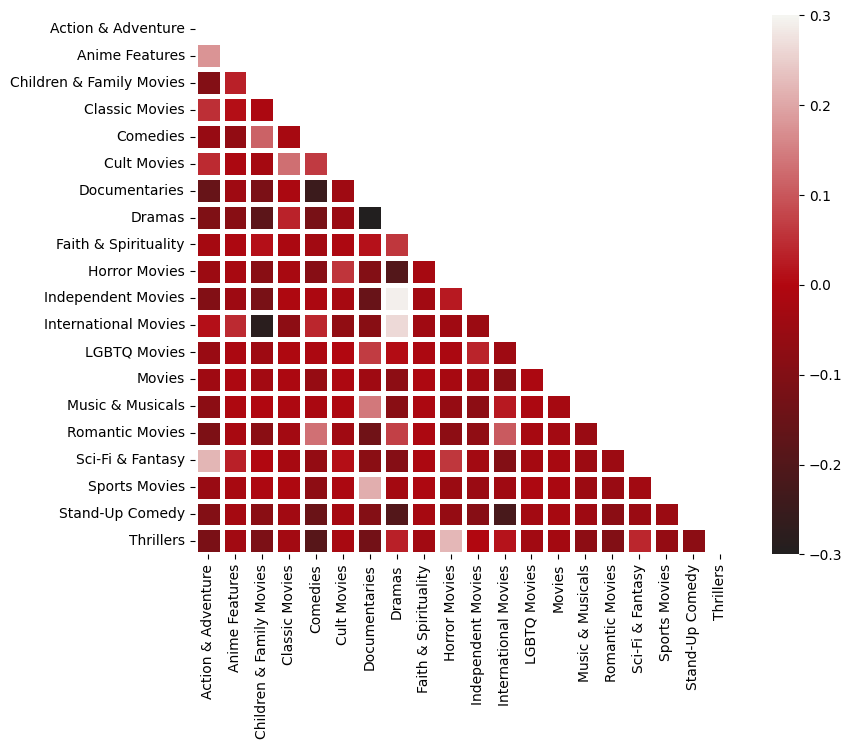

In [ ]:
df_tv = df[df["type"] == "TV Show"]
df_movies = df[df["type"] == "Movie"]


genre_heatmap(df_movies, 'Movie')
plt.show()

#### key takeaways
- Independent movies cluster with **Dramas**.
- International movies are rarely categorized for **Kids**.

### Overall Genre Distribution

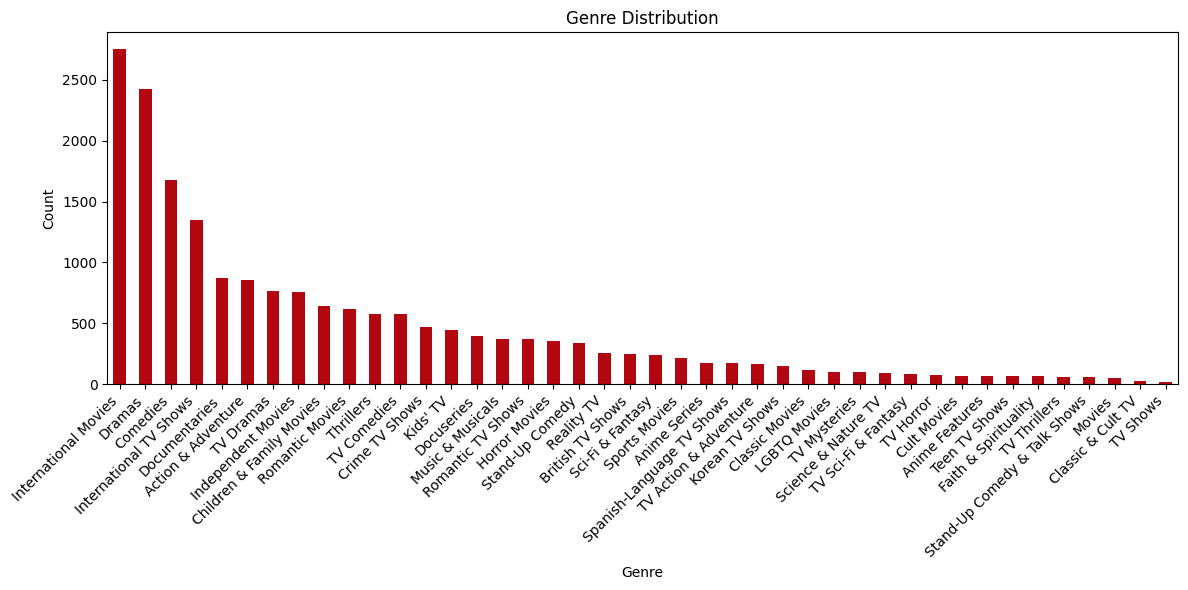

In [ ]:
# Flatten the list of genres
all_genres = [genre for sublist in df['genre'] for genre in sublist]

# Get value counts
genre_counts = pd.Series(all_genres).value_counts()

# Plot
plt.figure(figsize=(12,6))
genre_counts.plot(kind='bar', color='#b20710')
plt.title('Genre Distribution')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Key takeaways
- International movies tend to be the dominant genre across the platform.
- Excluding International movies and TV shows, Dramas and Comedies represent the majority of genres across Netflix.


### Genre Distribution for Movies and TV shows

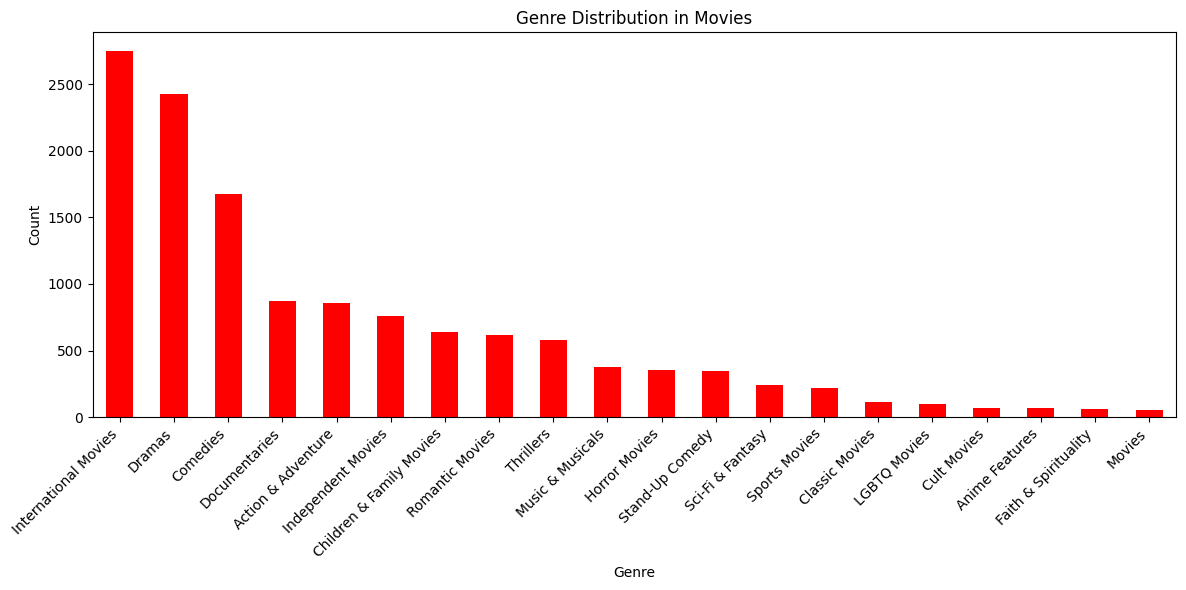

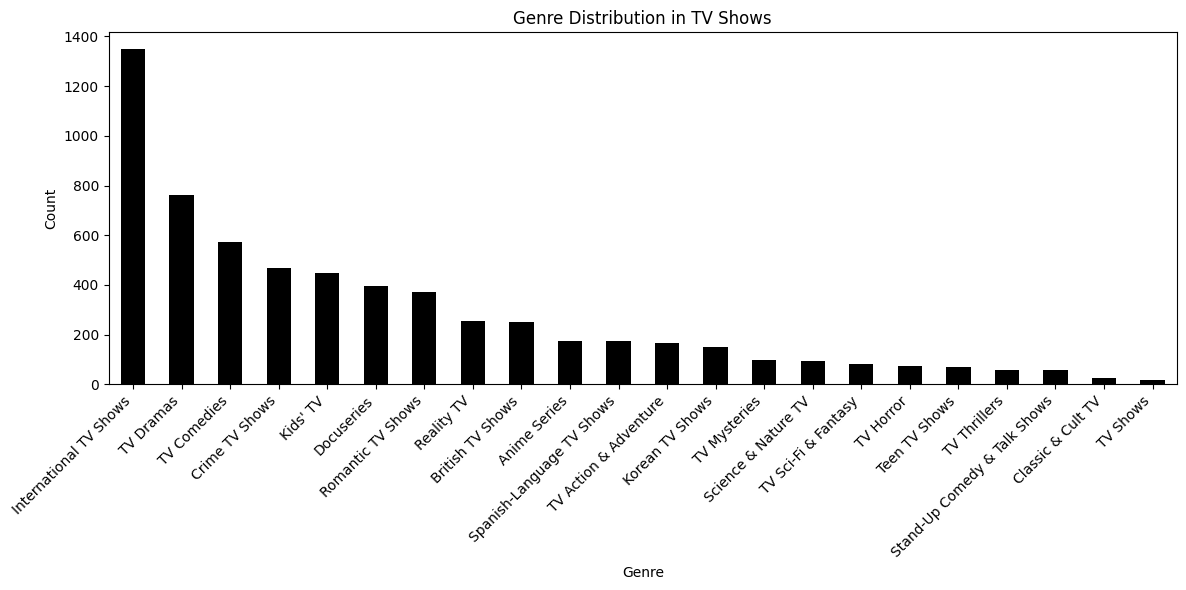

In [ ]:
# Get genres for Movies
movie_genres = [genre for sublist in df_movies['genre'] for genre in sublist]
movie_genre_counts = pd.Series(movie_genres).value_counts()

plt.figure(figsize=(12,6))
movie_genre_counts.plot(kind='bar', color='red')
plt.title('Genre Distribution in Movies')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Get genres for TV Shows
tv_genres = [genre for sublist in df_tv['genre'] for genre in sublist]
tv_genre_counts = pd.Series(tv_genres).value_counts()

plt.figure(figsize=(12,6))
tv_genre_counts.plot(kind='bar', color='black')
plt.title('Genre Distribution in TV Shows')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Key takeaways
- Movies: stronger presence in Dramas, International Movies, and Documentaries; action-adventure clusters are also common.
- TV Shows: stronger in International TV, Kids/Teen TV, and Reality/Docu-series categories.
- They both show the similar trend in genre distributin but in Movies we see more Dramas and Comedies than they are in TV shows.


## Directors Analysis:
top directors for Movies and TV Shows, plus distributions of titles per director for each type.

DIRECTORS ANALYSIS: MOVIES vs TV SHOWS

🎬 MOVIES ANALYSIS:
----------------------------------------
Maximum movies by a director: 19
Minimum movies by a director: 1
Directors with maximum movies (19): 1
Directors with minimum movies (1): 3520

📺 TV SHOWS ANALYSIS:
----------------------------------------
Maximum TV shows by a director: 3
Minimum TV shows by a director: 1
Directors with maximum TV shows (3): 1
Directors with minimum TV shows (1): 215


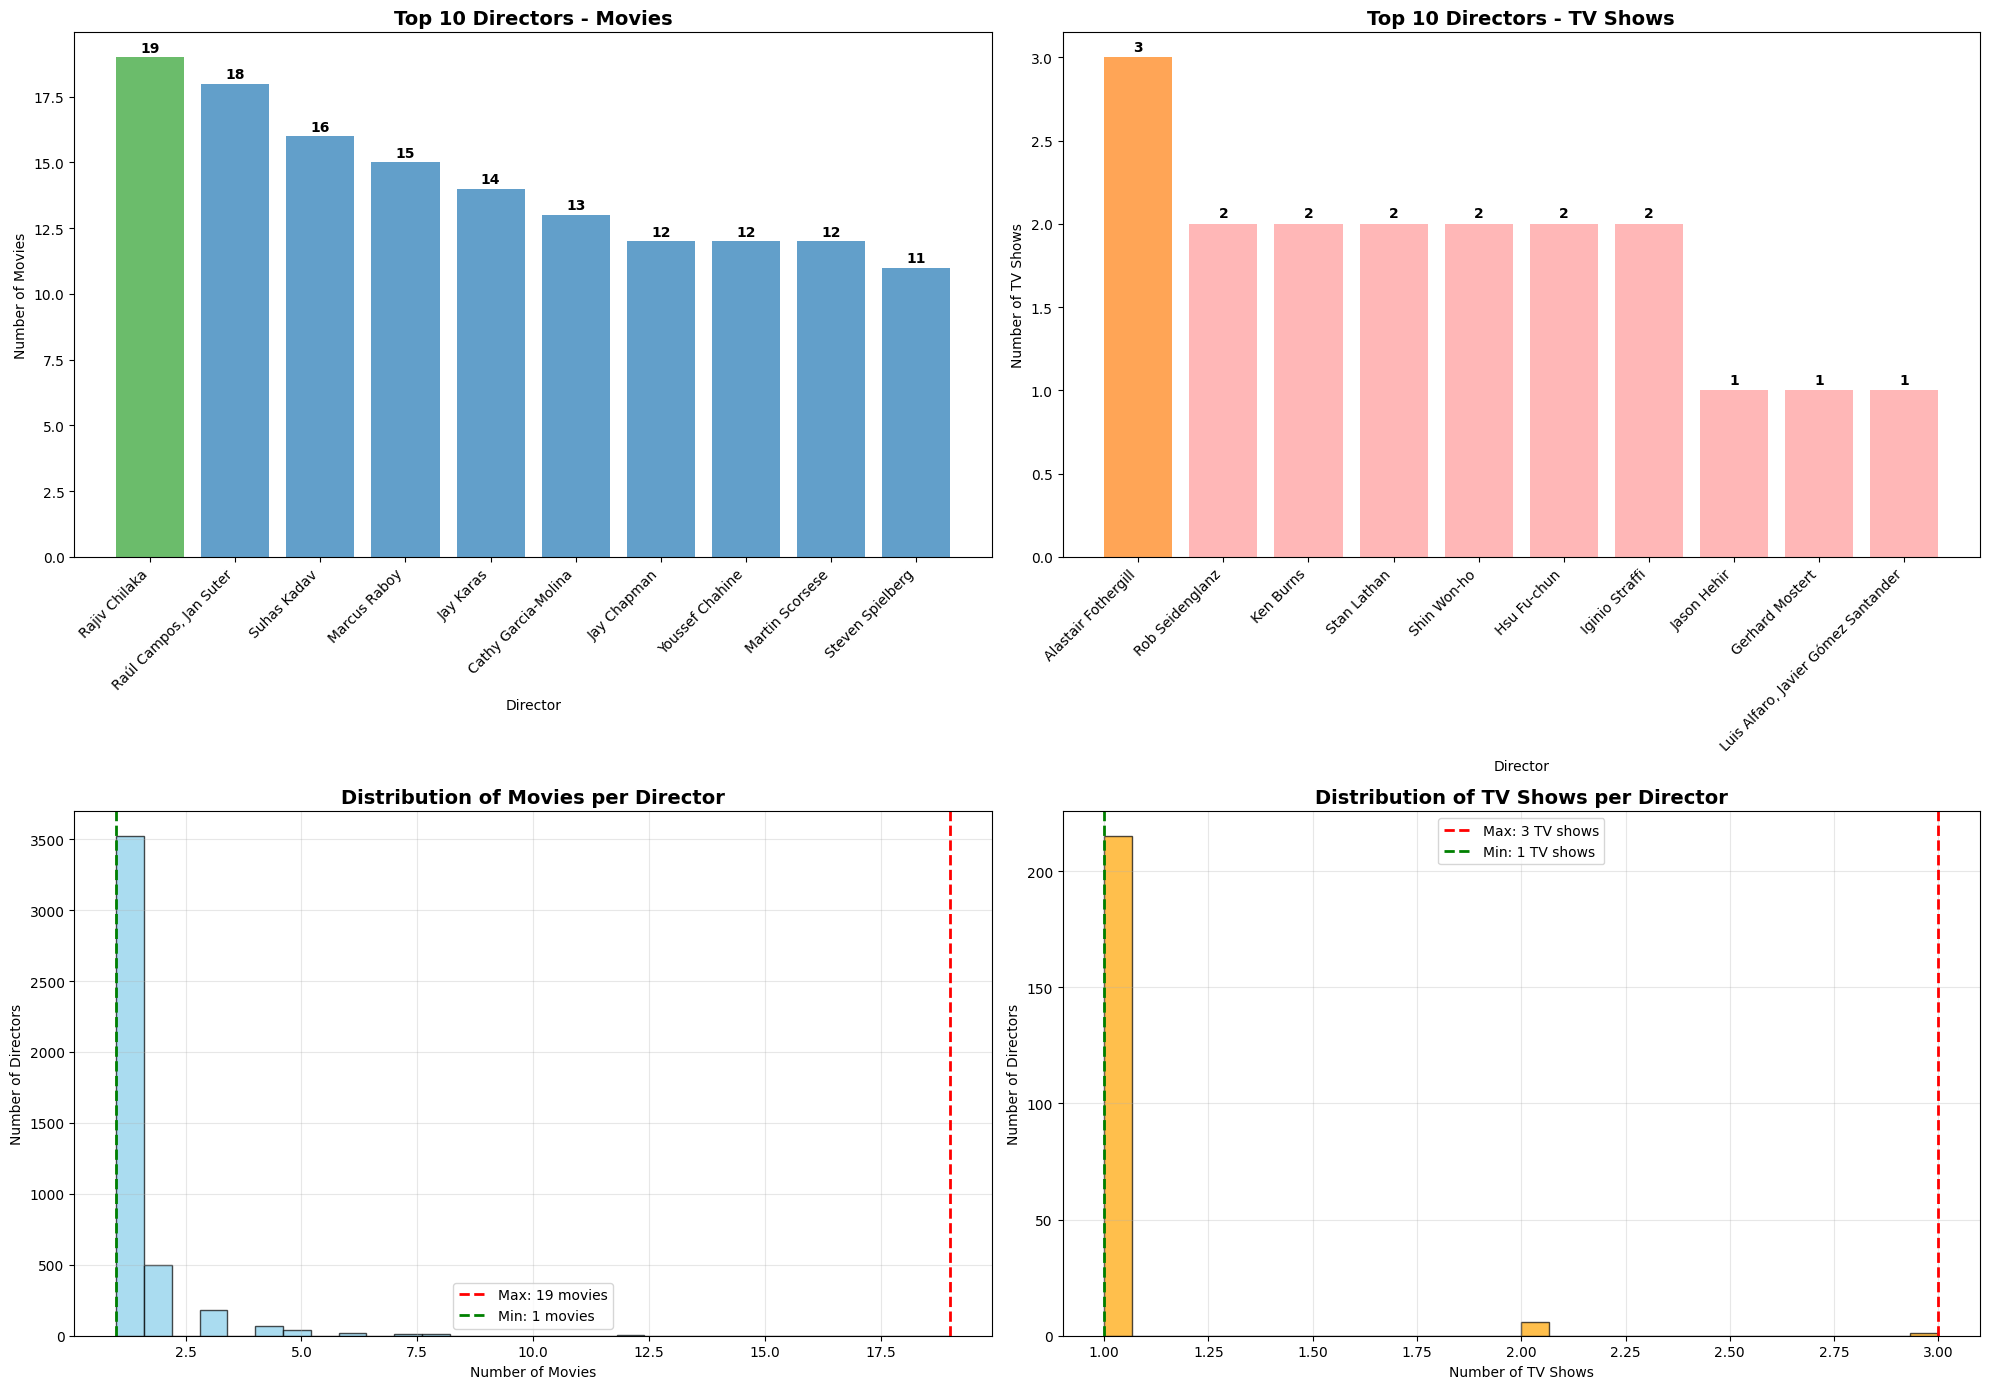


📊 SUMMARY COMPARISON:
----------------------------------------
Total unique movie directors: 4352
Total unique TV show directors: 222
Average movies per director: 1.36
Average TV shows per director: 1.04

🏆 TOP MOVIE DIRECTOR(S) (19 movies):
  - Rajiv Chilaka

🏆 TOP TV SHOW DIRECTOR(S) (3 TV shows):
  - Alastair Fothergill


In [ ]:
# Comprehensive analysis for BOTH Movies and TV Shows
print("="*80)
print("DIRECTORS ANALYSIS: MOVIES vs TV SHOWS")
print("="*80)

# Analysis for MOVIES
print("\n🎬 MOVIES ANALYSIS:")
print("-" * 40)
movie_directors = df_movies[df_movies['director'] != 'No Data']['director']
movie_director_counts = movie_directors.value_counts()

movie_max = movie_director_counts.max()
movie_min = movie_director_counts.min()
movie_directors_most = movie_director_counts[movie_director_counts == movie_max]
movie_directors_least = movie_director_counts[movie_director_counts == movie_min]

print(f"Maximum movies by a director: {movie_max}")
print(f"Minimum movies by a director: {movie_min}")
print(f"Directors with maximum movies ({movie_max}): {len(movie_directors_most)}")
print(f"Directors with minimum movies ({movie_min}): {len(movie_directors_least)}")

# Analysis for TV SHOWS
print("\n📺 TV SHOWS ANALYSIS:")
print("-" * 40)
tv_directors = df_tv[df_tv['director'] != 'No Data']['director']
tv_director_counts = tv_directors.value_counts()

tv_max = tv_director_counts.max()
tv_min = tv_director_counts.min()
tv_directors_most = tv_director_counts[tv_director_counts == tv_max]
tv_directors_least = tv_director_counts[tv_director_counts == tv_min]

print(f"Maximum TV shows by a director: {tv_max}")
print(f"Minimum TV shows by a director: {tv_min}")
print(f"Directors with maximum TV shows ({tv_max}): {len(tv_directors_most)}")
print(f"Directors with minimum TV shows ({tv_min}): {len(tv_directors_least)}")

# Create side-by-side comparison plots
fig, axes = plt.subplots(2, 2, figsize=(20, 14))

# Top 10 Movie Directors
ax1 = axes[0, 0]
top_movie_directors = movie_director_counts.head(10)
colors_movies = ['#2ca02c' if count == movie_max else '#1f77b4' for count in top_movie_directors.values]
bars1 = ax1.bar(range(len(top_movie_directors)), top_movie_directors.values, color=colors_movies, alpha=0.7)
ax1.set_title('Top 10 Directors - Movies', fontsize=14, fontweight='bold')
ax1.set_xlabel('Director')
ax1.set_ylabel('Number of Movies')
ax1.set_xticks(range(len(top_movie_directors)))
ax1.set_xticklabels(top_movie_directors.index, rotation=45, ha='right')

# Add value labels
for i, (bar, value) in enumerate(zip(bars1, top_movie_directors.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             str(value), ha='center', va='bottom', fontweight='bold')

# Top 10 TV Show Directors
ax2 = axes[0, 1]
top_tv_directors = tv_director_counts.head(10)
colors_tv = ['#ff7f0e' if count == tv_max else '#ff9999' for count in top_tv_directors.values]
bars2 = ax2.bar(range(len(top_tv_directors)), top_tv_directors.values, color=colors_tv, alpha=0.7)
ax2.set_title('Top 10 Directors - TV Shows', fontsize=14, fontweight='bold')
ax2.set_xlabel('Director')
ax2.set_ylabel('Number of TV Shows')
ax2.set_xticks(range(len(top_tv_directors)))
ax2.set_xticklabels(top_tv_directors.index, rotation=45, ha='right')

# Add value labels
for i, (bar, value) in enumerate(zip(bars2, top_tv_directors.values)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             str(value), ha='center', va='bottom', fontweight='bold')

# Distribution of Movies per Director
ax3 = axes[1, 0]
ax3.hist(movie_director_counts.values, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
ax3.axvline(movie_max, color='red', linestyle='--', linewidth=2, label=f'Max: {movie_max} movies')
ax3.axvline(movie_min, color='green', linestyle='--', linewidth=2, label=f'Min: {movie_min} movies')
ax3.set_title('Distribution of Movies per Director', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Movies')
ax3.set_ylabel('Number of Directors')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Distribution of TV Shows per Director
ax4 = axes[1, 1]
ax4.hist(tv_director_counts.values, bins=30, color='orange', alpha=0.7, edgecolor='black')
ax4.axvline(tv_max, color='red', linestyle='--', linewidth=2, label=f'Max: {tv_max} TV shows')
ax4.axvline(tv_min, color='green', linestyle='--', linewidth=2, label=f'Min: {tv_min} TV shows')
ax4.set_title('Distribution of TV Shows per Director', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of TV Shows')
ax4.set_ylabel('Number of Directors')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary comparison
print("\n📊 SUMMARY COMPARISON:")
print("-" * 40)
print(f"Total unique movie directors: {len(movie_director_counts)}")
print(f"Total unique TV show directors: {len(tv_director_counts)}")
print(f"Average movies per director: {movie_director_counts.mean():.2f}")
print(f"Average TV shows per director: {tv_director_counts.mean():.2f}")

# Show the top directors for each category
print(f"\n🏆 TOP MOVIE DIRECTOR(S) ({movie_max} movies):")
for director in movie_directors_most.index:
    print(f"  - {director}")

print(f"\n🏆 TOP TV SHOW DIRECTOR(S) ({tv_max} TV shows):")
for director in tv_directors_most.index:
    print(f"  - {director}")


### Key takeaways
- Very long‑tail: most directors have a single title; only a few have many.
- From the printed summary: Rajiv Chilaka leads Movies (~19). For TV Shows, top counts are much lower (e.g., ~3) with Alastair Fothergill among the leaders.
- The histograms emphasize skewness: concentrated output among a handful of creators with wide dispersion at the low end.


## Ratings
### Target Age Groups:

In [ ]:
# Quick feature engineering

# Rating ages from this notebook: https://www.kaggle.com/andreshg/eda-beginner-to-expert-plotly 

ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()



array(['Teens', 'Adults', 'Older Kids', 'Kids'], dtype=object)

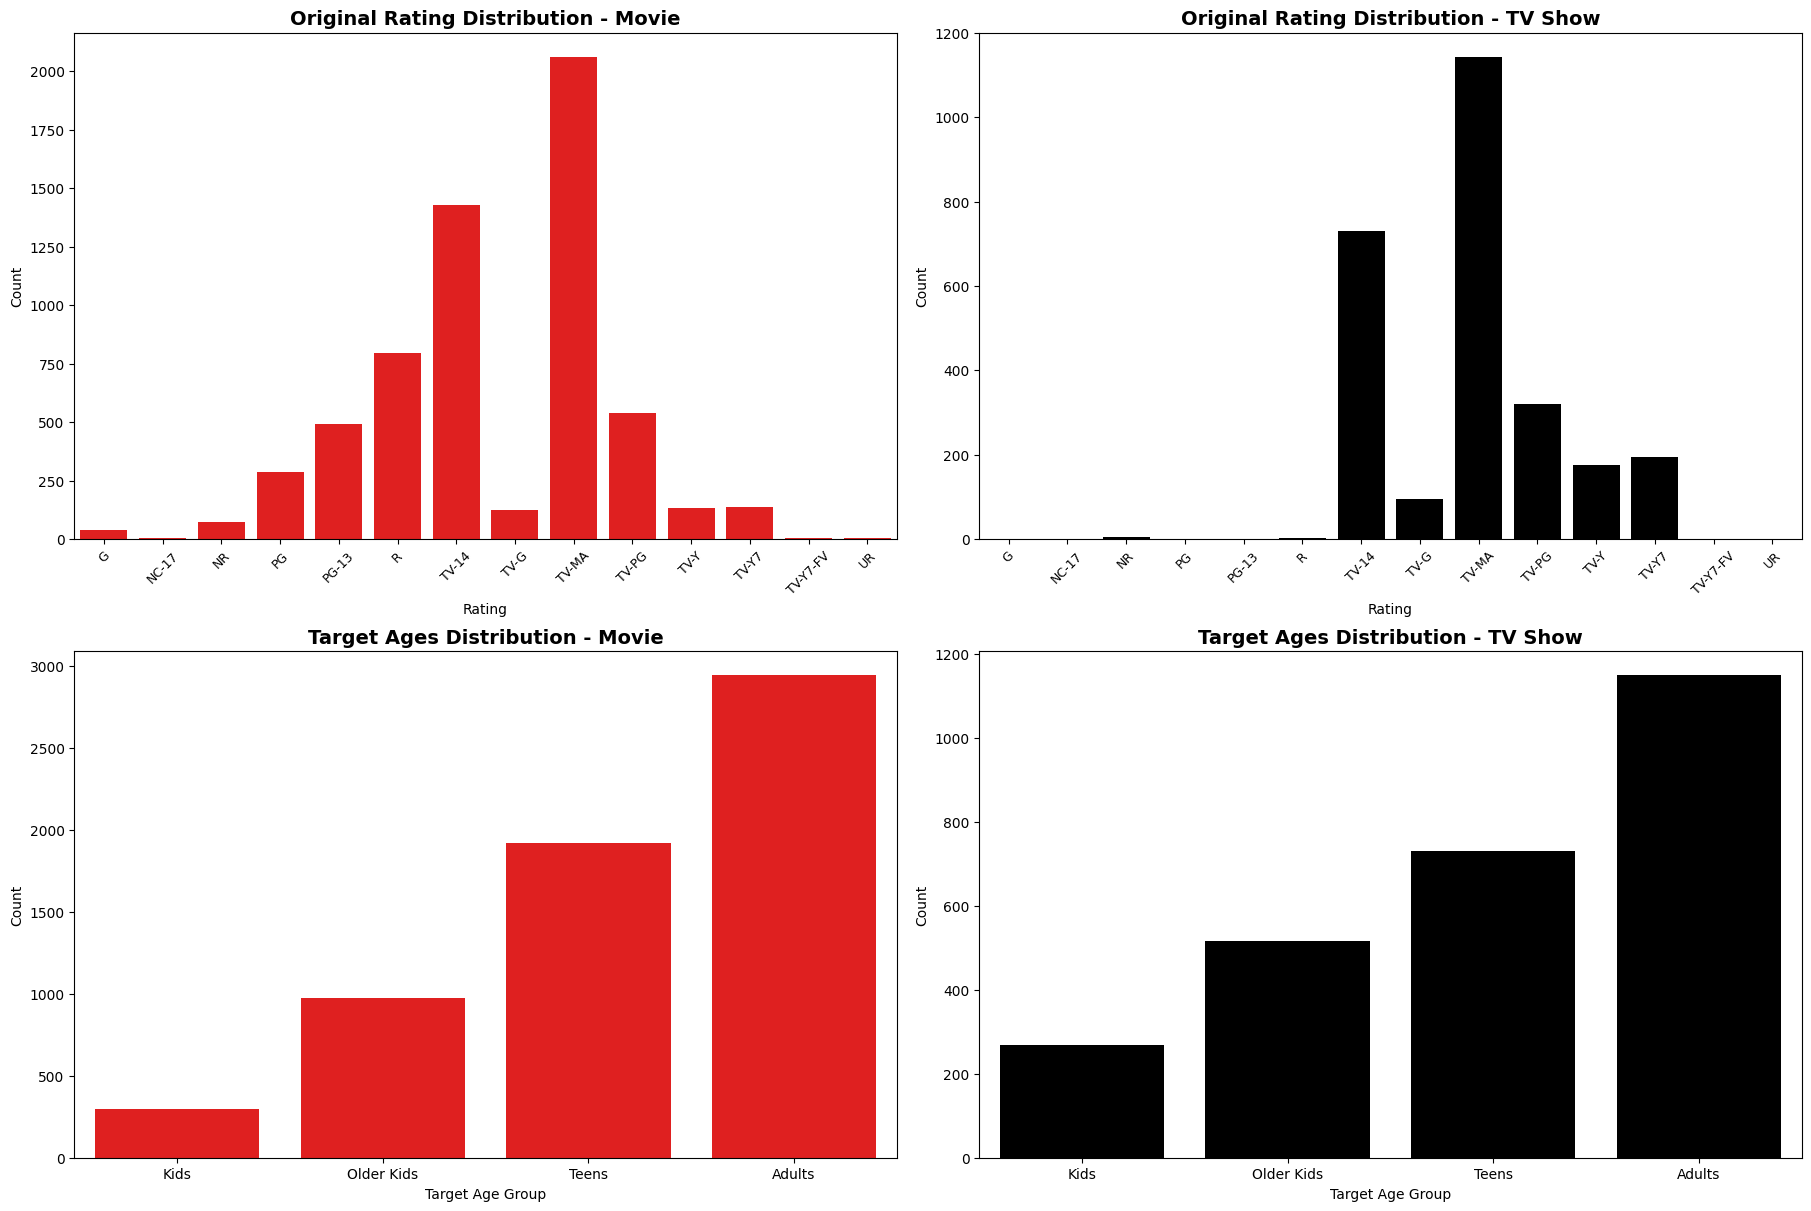

In [ ]:

# Ensure target_ages exists (in case the cell above wasn't run)
if 'target_ages' not in df.columns:
    ratings_ages = {
        'TV-PG': 'Older Kids','TV-MA': 'Adults','TV-Y7-FV': 'Older Kids','TV-Y7': 'Older Kids',
        'TV-14': 'Teens','R': 'Adults','TV-Y': 'Kids','NR': 'Adults','PG-13': 'Teens',
        'TV-G': 'Kids','PG': 'Older Kids','G': 'Kids','UR': 'Adults','NC-17': 'Adults'
    }
    df['target_ages'] = df['rating'].replace(ratings_ages)

# Orders and types
rating_order = sorted([r for r in df['rating'].dropna().unique().tolist()])
age_order = ['Kids', 'Older Kids', 'Teens', 'Adults']
content_types = ['Movie', 'TV Show']

# Cast types for safe filtering and ordering
df['type'] = df['type'].astype(str)
df['rating'] = pd.Categorical(df['rating'], categories=rating_order, ordered=True)
df['target_ages'] = pd.Categorical(df['target_ages'], categories=age_order, ordered=True)

fig, axes = plt.subplots(2, 2, figsize=(18, 12), constrained_layout=True)

# Top row: Original rating distribution by type
for col_idx, ctype in enumerate(content_types):
    ax = axes[0, col_idx]
    subset = df[df['type'] == ctype].copy()
    # Drop NAs to avoid seaborn errors
    subset = subset.dropna(subset=['rating'])
    sns.countplot(
        data=subset,
        x='rating',
        order=rating_order,
        color='red' if ctype == 'Movie' else 'black',
        ax=ax
    )
    ax.set_title(f'Original Rating Distribution - {ctype}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45, labelsize=9)

# Bottom row: Target ages distribution by type
for col_idx, ctype in enumerate(content_types):
    ax = axes[1, col_idx]
    subset = df[df['type'] == ctype].copy()
    subset = subset.dropna(subset=['target_ages'])
    sns.countplot(
        data=subset,
        x='target_ages',
        order=age_order,
        color='red' if ctype == 'Movie' else 'black',
        ax=ax
    )
    ax.set_title(f'Target Ages Distribution - {ctype}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Target Age Group')
    ax.set_ylabel('Count')

plt.show()



#### key takeaways
- TV ratings (e.g., TV-MA, TV-14) dominate TV Shows; Movies are distributed across MPAA ratings (e.g., PG-13, R, PG).
- TV Shows often skew toward Teens/Adults; Movies show a broader spread including Kids/Older Kids.
- For the Target age groups they both show the similar trend, highlighting that most of the categories are made for adults.


### Target Age Groups vs. Genres
Heatmap of target age groups versus top genres (row-normalized percentages).

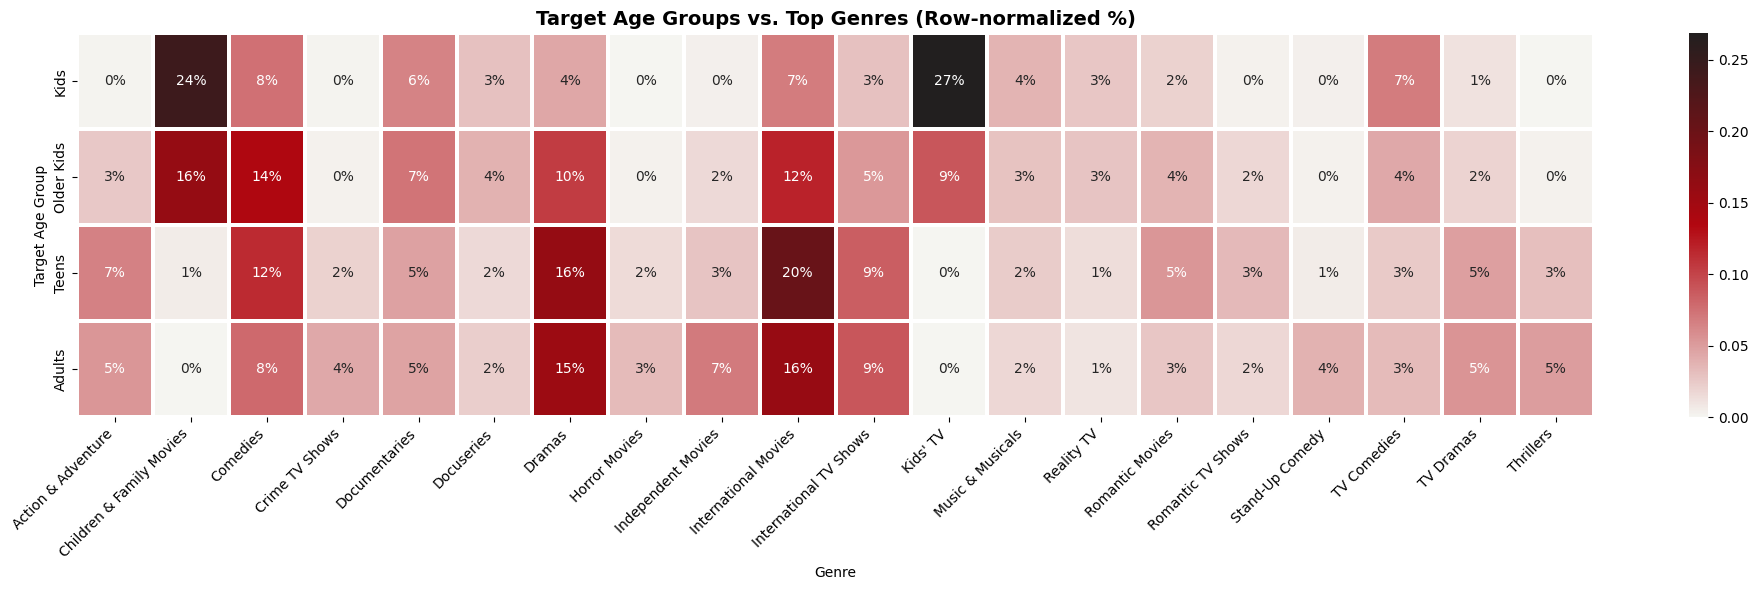

In [ ]:

# Ensure genre exists as list
if 'genre' not in df.columns:
    df['genre'] = df['listed_in'].str.replace(' ,', ',', regex=False).str.replace(', ', ',', regex=False).str.split(',')

# Explode genres and clean
age_genre = df[['target_ages', 'genre']].copy()
age_genre = age_genre.explode('genre').dropna()
age_genre['genre'] = age_genre['genre'].astype(str).str.strip()

# Optional: focus on top N genres for readability
N = 20
top_genres = age_genre['genre'].value_counts().head(N).index.tolist()
age_genre_top = age_genre[age_genre['genre'].isin(top_genres)]

# Orders
age_order = ['Kids', 'Older Kids', 'Teens', 'Adults']

# Crosstab and row-normalize (percent per age group)
ct = pd.crosstab(age_genre_top['target_ages'], age_genre_top['genre'])
ct = ct.reindex(index=age_order)
ct_pct = ct.div(ct.sum(axis=1).replace(0, np.nan), axis=0)

# Fallback colormap if 'cmap' not defined
try:
    cmap_to_use = cmap
except NameError:
    import matplotlib.colors as mcolors
    cmap_to_use = mcolors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710', '#f5f5f1'])

plt.figure(figsize=(20, 6))
sns.heatmap(ct_pct, cmap=cmap_to_use.reversed(), linewidth=1.5, linecolor='white', cbar=True,
            annot=True, fmt='.0%', vmin=0, vmax=ct_pct.values.max(),
            annot_kws={"fontsize":10})
plt.title('Target Age Groups vs. Top Genres (Row-normalized %)', fontsize=14, fontweight='bold')
plt.xlabel('Genre')
plt.ylabel('Target Age Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### key takeaways
- Kids/Older Kids are concentrated in Family, Children, and Animation-adjacent genres.
- International movies and Dramas skew more towards Teens and adults.
- Stand-up comedy, thriller, and horror are rarely suitable for kids.


## Country

In [ ]:
# Short country mapping
country_short_map = {
    'United States': 'USA',
    'United Kingdom': 'UK',
    'South Korea': 'S. Korea',
    'Korea, Republic of': 'S. Korea',
}
first_country_series = df['first_country'].fillna('Unknown').astype(str)
first_country_short = first_country_series.replace(country_short_map)

# Determine top countries by count (using short names)
counts_by_country = first_country_short.value_counts()
top_countries_short = counts_by_country.head(10).index.tolist()

# Orders
age_order = ['Kids','Older Kids','Teens','Adults']
country_order2 = ['USA', 'India', 'UK', 'Canada', 'Japan', 'France', 'S. Korea', 'Spain', 'Mexico']

# Build crosstab and normalize per column
mask = first_country_short.isin(top_countries_short)
ct = pd.crosstab(df.loc[mask, 'target_ages'], first_country_short[mask])
ct = ct.reindex(index=age_order)
ct = ct.reindex(columns=country_order2)

df_heatmap = ct.div(ct.sum(axis=0).replace(0, np.nan), axis=1)


### Country vs. Target Age Groups:
Normalized heatmap of target age distribution within top countries.


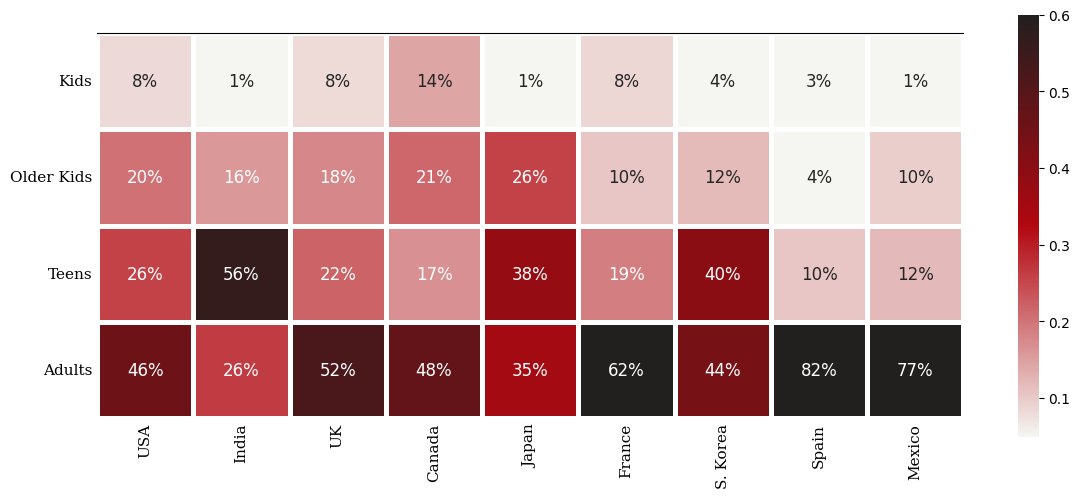

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

country_order2 = ['USA', 'India', 'UK', 'Canada', 'Japan', 'France', 'S. Korea', 'Spain',
       'Mexico']

age_order = ['Kids','Older Kids','Teens','Adults']

sns.heatmap(df_heatmap.loc[age_order,country_order2],cmap=cmap.reversed(),square=True, linewidth=2.5,cbar=True,
            annot=True,fmt='.0%',vmax=.6,vmin=0.05,ax=ax,annot_kws={"fontsize":12})

ax.spines['top'].set_visible(True)

ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.show()


#### key takeaways
- Profiles vary by country: some skew **Adults**, others **Kids/Older Kids**.
- **India** has >50% targeting **Teens**.
- **Canada** has the highest **Kids** share (~14%).
- **Spain** has the highest **Adults** share (~82%).


## Release-date
### Number of releases over time : Movies vs. TV shows

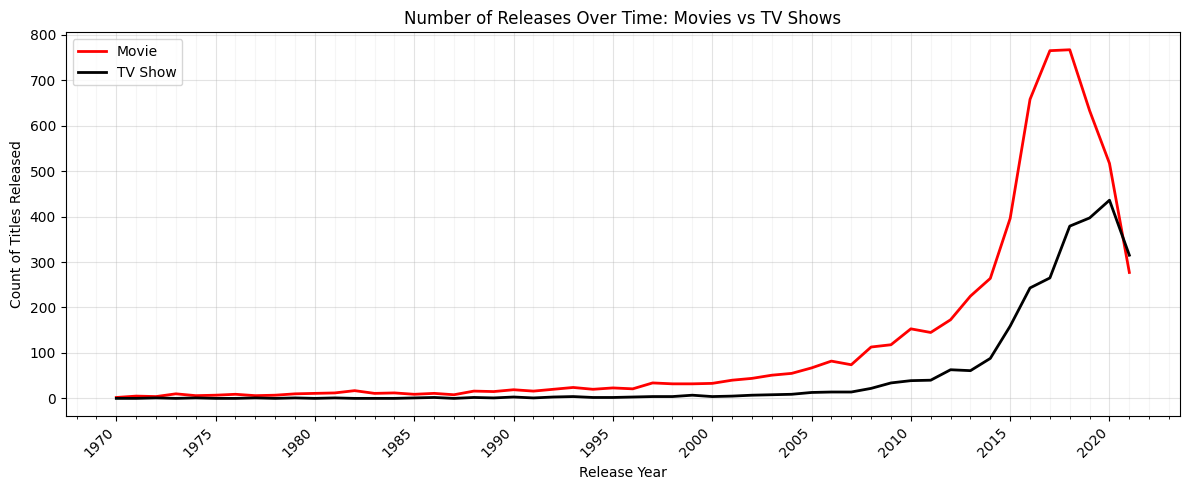

In [ ]:
# Movies vs TV Shows releases over time (one line plot)
# Aggregate yearly counts by type
counts_by_year_type = (
    df.groupby(['release_year', 'type'])
      .size()
      .reset_index(name='count')
)

# Pivot to have separate columns for Movie and TV Show
yearly_pivot = (
    counts_by_year_type
    .pivot(index='release_year', columns='type', values='count')
    .fillna(0)
    .sort_index()
)

# Optional: focus on a reasonable year window where data is dense
# Restrict range to 1970 onwards
yearly_pivot = yearly_pivot.loc[yearly_pivot.index >= 1970]

from matplotlib.ticker import MultipleLocator, ScalarFormatter

plt.figure(figsize=(12,5))
for col, color in [('Movie', 'red'), ('TV Show', 'black')]:
    if col in yearly_pivot.columns:
        plt.plot(yearly_pivot.index, yearly_pivot[col], label=col, color=color, linewidth=2)

plt.title('Number of Releases Over Time: Movies vs TV Shows')
plt.xlabel('Release Year')
plt.ylabel('Count of Titles Released')
plt.legend()

# Make the year axis more distinguishable
ax = plt.gca()
min_year = int(yearly_pivot.index.min())
max_year = int(yearly_pivot.index.max())
span = max_year - min_year
step = 5 if span > 30 else 2
first_tick = min_year - (min_year % step)
if first_tick < min_year:
    first_tick += step
major_ticks = list(range(first_tick, max_year + 1, step))
ax.set_xticks(major_ticks)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.xticks(rotation=45, ha='right')

# Subtle grid with both major and minor ticks
ax.grid(which='major', alpha=0.35)
ax.grid(which='minor', alpha=0.12)

plt.tight_layout()
plt.show()


#### key takeaways
- **Movies** outnumber **TV Shows** across years.
- **TV Shows** accelerate after 2016, briefly surpassing Movies around 2018.


### Release Year vs. Target Age Groups

C:\Users\aamin\AppData\Local\Temp\ipykernel_21736\2865802481.py:7: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  movies.pivot_table(index='release_year', columns='target_ages', values='show_id', aggfunc='count', fill_value=0)


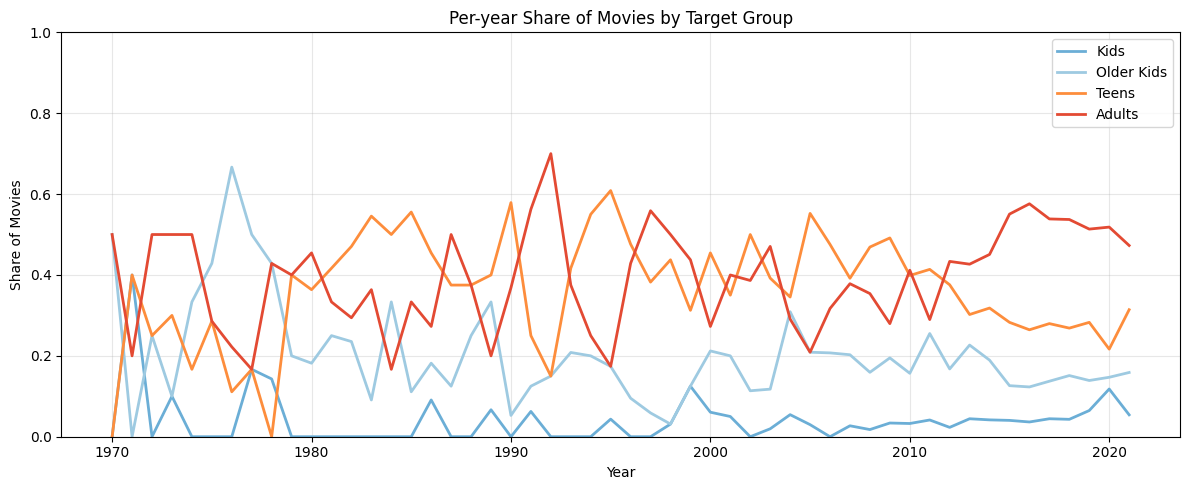

Adults dominant in 23 year(s) since 1970.
First years: [1972, 1973, 1974, 1980, 1987, 1991, 1992, 1997, 1998, 1999]
Last years: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


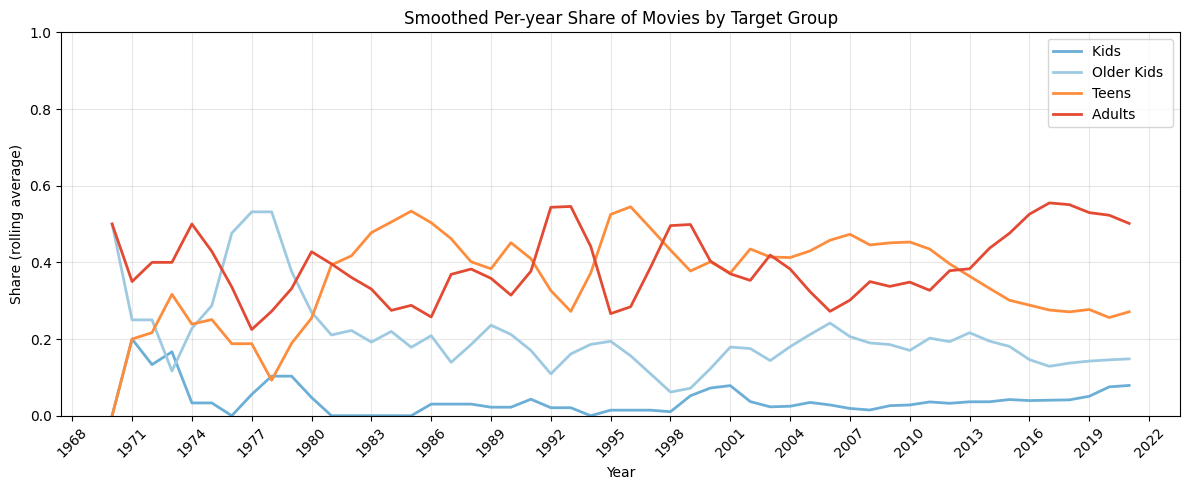

In [ ]:

# Movies only, filter to 1970+
movies = df[(df['type'] == 'Movie') & (df['release_year'] >= 1970)].copy()
movies = movies.dropna(subset=['release_year', 'target_ages'])

# Year x target group counts
counts_year_age = (
    movies.pivot_table(index='release_year', columns='target_ages', values='show_id', aggfunc='count', fill_value=0)
    .sort_index()
)

# Keep consistent column order if available
age_order = ['Kids', 'Older Kids', 'Teens', 'Adults']
cols = [c for c in age_order if c in counts_year_age.columns]
counts_year_age = counts_year_age[cols]

# 2) Relative proportions per year to see dominance
shares = counts_year_age.div(counts_year_age.sum(axis=1).replace(0, np.nan), axis=0)
plt.figure(figsize=(12,5))
colors = {'Kids':'#6baed6','Older Kids':'#9ecae1','Teens':'#fd8d3c','Adults':'#e34a33'}
for col in cols:
    plt.plot(shares.index, shares[col], label=col, color=colors.get(col, None), linewidth=2)
plt.title('Per-year Share of Movies by Target Group')
plt.xlabel('Year')
plt.ylabel('Share of Movies')
plt.legend()
ax = plt.gca()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3) Identify years where Adults had the highest share
if 'Adults' in shares.columns:
    dominant_group = shares.idxmax(axis=1)
    adults_dominant_years = dominant_group[dominant_group == 'Adults'].index.tolist()
    print(f"Adults dominant in {len(adults_dominant_years)} year(s) since 1970.")
    # Show first and last few for brevity
    if adults_dominant_years:
        preview = adults_dominant_years[:10]
        tail = adults_dominant_years[-10:]
        print('First years:', preview)
        if len(adults_dominant_years) > 10:
            print('Last years:', tail)
else:
    print('Adults group not present in data to compute dominance.')

# Optional: smooth shares to see trends
window = 3
shares_rolled = shares.rolling(window=window, min_periods=1).mean()
plt.figure(figsize=(12,5))
for col in cols:
    plt.plot(shares_rolled.index, shares_rolled[col], label=f"{col} ", color=colors.get(col, None), linewidth=2)
plt.title('Smoothed Per-year Share of Movies by Target Group')
plt.xlabel('Year')
plt.ylabel('Share (rolling average)')
plt.legend()
ax = plt.gca()
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both', nbins=20))
ax.tick_params(axis='x', rotation=45, labelsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### key takeaways
- **Adults** dominate many years; strongest in the 2010s.
- Early peaks vary: **Older Kids** peak in 1977; **Teens** surge late 1970s–1990.
- Post‑2012 shift toward **Adults**, peaking around 2017.

## Date-added

C:\Users\aamin\AppData\Local\Temp\ipykernel_21736\1380381846.py:14: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()


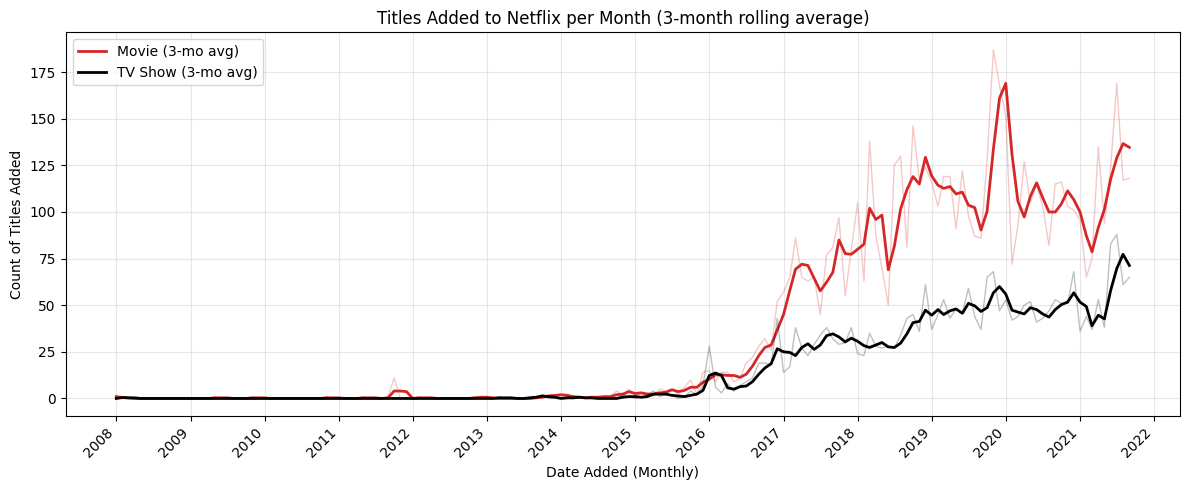

In [ ]:
# Titles added to Netflix over time by type (Movies vs TV Shows)
# Ensure date_added is datetime
if not np.issubdtype(df['date_added'].dtype, np.datetime64):
    df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', errors='coerce')

added = df.dropna(subset=['date_added', 'type']).copy()
added['type'] = added['type'].astype(str)

# Resample by month to smooth daily noise
monthly = (
    added.set_index('date_added')
         .groupby('type')
         .resample('MS')  # Month start frequency
         .size()
         .unstack(0)
         .fillna(0)
         .sort_index()
)

# Optional: focus on modern Netflix catalog period
# monthly = monthly.loc[monthly.index >= '2015-01-01']

plt.figure(figsize=(12,5))
colors = {'Movie':'#d62728', 'TV Show':'#000000'}  # red for movies, black for TV

# 3-month rolling average for smoothing
smoothed = monthly.rolling(window=3, min_periods=1).mean()

for col in ['Movie', 'TV Show']:
    if col in monthly.columns:
        # Plot original lightly for context
        plt.plot(monthly.index, monthly[col], color=colors.get(col), alpha=0.25, linewidth=1)
        # Plot smoothed prominently
        plt.plot(smoothed.index, smoothed[col], label=f"{col} (3-mo avg)", color=colors.get(col), linewidth=2)

plt.title('Titles Added to Netflix per Month (3-month rolling average)')
plt.xlabel('Date Added (Monthly)')
plt.ylabel('Count of Titles Added')
plt.legend()

# Improve date ticks
ax = plt.gca()
from matplotlib.dates import YearLocator, DateFormatter
ax.xaxis.set_major_locator(YearLocator(base=1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### key takeaways
- Distinct cycles: **Movies** added in larger, more volatile batches; **TV Shows** in steadier waves.
- Late 2019: added Movies peaked at ~180.
- 2020: notable drop in Movies, likely impacted by COVID‑19.
